In [42]:
type2id = dict()

for i in range(-100, 101):
    type2id[str(i)] = i + 100

for up in [chr(i) for i in range(65, 91)]:
    type2id[up] = ord(up) - 65 + 201

for low in [chr(i) for i in range(97, 123)]:
    type2id[low] = ord(low) - 97 + 227

list(type2id.keys())

['-100',
 '-99',
 '-98',
 '-97',
 '-96',
 '-95',
 '-94',
 '-93',
 '-92',
 '-91',
 '-90',
 '-89',
 '-88',
 '-87',
 '-86',
 '-85',
 '-84',
 '-83',
 '-82',
 '-81',
 '-80',
 '-79',
 '-78',
 '-77',
 '-76',
 '-75',
 '-74',
 '-73',
 '-72',
 '-71',
 '-70',
 '-69',
 '-68',
 '-67',
 '-66',
 '-65',
 '-64',
 '-63',
 '-62',
 '-61',
 '-60',
 '-59',
 '-58',
 '-57',
 '-56',
 '-55',
 '-54',
 '-53',
 '-52',
 '-51',
 '-50',
 '-49',
 '-48',
 '-47',
 '-46',
 '-45',
 '-44',
 '-43',
 '-42',
 '-41',
 '-40',
 '-39',
 '-38',
 '-37',
 '-36',
 '-35',
 '-34',
 '-33',
 '-32',
 '-31',
 '-30',
 '-29',
 '-28',
 '-27',
 '-26',
 '-25',
 '-24',
 '-23',
 '-22',
 '-21',
 '-20',
 '-19',
 '-18',
 '-17',
 '-16',
 '-15',
 '-14',
 '-13',
 '-12',
 '-11',
 '-10',
 '-9',
 '-8',
 '-7',
 '-6',
 '-5',
 '-4',
 '-3',
 '-2',
 '-1',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 

In [1]:
import wandb

wandb.login(key="1dd5638ff742d2a11893d11a3b62e9522efd629c")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/chenyang/.netrc


True

In [2]:
import sys

In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiler_version())
print(get_compiling_cuda_version())

/home/chenyang/software/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0 True
GCC 7.3
11.3


In [4]:
import mmdet
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

import random
import numpy as np
from pathlib import Path
import copy
import json
from pycocotools.coco import COCO
import os

In [5]:
seed = 42

"""Sets the random seeds."""
set_random_seed(seed, deterministic=False)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
random.seed(seed)

def create_subset(c, cats, valid_n = 3000,test_n=3000):
    new_coco = {}
    cat_ids = c.getCatIds(cats)
    train_img_ids = set()
    valid_img_ids = set()
    test_img_ids = set()
    for cat in cat_ids[::-1]:                                    # 按照检测种类均匀分配图片
        img_ids = copy.copy(c.getImgIds(catIds=[cat]))
        random.shuffle(img_ids)
        tn = max(int(len(img_ids) / 10), 1)
        vn = max(int(len(img_ids) / 10), 1)
        new_test = set(img_ids[:tn])
        new_valid = set(img_ids[tn:tn + vn])
        exist_test_ids = new_test.intersection(train_img_ids)    # 找到交集（有些图片在其他物品特征处理的时候已经分到了train中）
        exist_test_ids_in_valid = new_test.intersection(new_valid)
        a = new_test.intersection(valid_img_ids)
        b = new_test.intersection(test_img_ids)
        exist_valid_ids = new_valid.intersection(train_img_ids)
        d = new_valid.intersection(valid_img_ids)
        e = new_valid.intersection(test_img_ids)
        f = new_valid.intersection(new_test)
        test_ids = new_test.difference(new_valid).difference(train_img_ids).difference(valid_img_ids).difference(test_img_ids) # 挑出new_test中不是交集的部分
        valid_ids = new_valid.difference(new_test).difference(train_img_ids).difference(valid_img_ids).difference(test_img_ids)
        train_ids = set(img_ids).difference(new_valid).difference(new_test).difference(train_img_ids).difference(valid_img_ids).difference(test_img_ids)
#         print(tn, vn, len(img_ids), len(new_test), len(test_ids), len(new_valid), len(valid_ids),len(train_ids))
        print(int(cat) - 101, ":", len(train_ids), len(valid_ids), len(test_ids))
        train_img_ids.update(train_ids)
        test_img_ids.update(test_ids)
        valid_img_ids.update(valid_ids)
#         print(len(test_img_ids))

    # prune duplicates
    dup_test = train_img_ids.intersection(test_img_ids)
    dup_valid = train_img_ids.intersection(valid_img_ids)
    train_img_ids = train_img_ids - dup_test - valid_img_ids
    
    train_anno_ids = set()
    test_anno_ids = set()
    valid_anno_ids = set()
    for cat in cat_ids:
        train_anno_ids.update(c.getAnnIds(imgIds=list(train_img_ids), catIds=[cat]))
        test_anno_ids.update(c.getAnnIds(imgIds=list(test_img_ids), catIds=[cat]))
        valid_anno_ids.update(c.getAnnIds(imgIds=list(valid_img_ids), catIds=[cat]))

    assert len(train_img_ids.intersection(test_img_ids)) == 0, 'img id conflicts with test, {} '.format(train_img_ids.intersection(test_img_ids))
    assert len(train_anno_ids.intersection(test_anno_ids)) == 0, 'anno id conflicts with test'
    assert len(train_img_ids.intersection(valid_img_ids)) == 0, 'img id conflicts with valid, {} '.format(train_img_ids.intersection(valid_img_ids))
    assert len(train_anno_ids.intersection(valid_anno_ids)) == 0, 'anno id conflicts with valid'
    print('train img ids #:', len(train_img_ids), 'train anno #:', len(train_anno_ids))
    print('valid img ids #:', len(valid_img_ids), 'valid anno #:', len(valid_anno_ids))
    print('test img ids #:', len(test_img_ids), 'test anno #:', len(test_anno_ids))
    new_coco_test = copy.deepcopy(new_coco)
    new_coco_valid = copy.deepcopy(new_coco)

    new_coco["images"] = c.loadImgs(list(train_img_ids))
    new_coco["annotations"] = c.loadAnns(list(train_anno_ids))
    
    for ann in new_coco["annotations"]:
        ann.pop('segmentation', None)
    new_coco["categories"] = c.loadCats(cat_ids)
    
    new_coco_valid['images'] = c.loadImgs(list(valid_img_ids))
    new_coco_valid['annotations'] = c.loadAnns(list(valid_anno_ids))
    
    new_coco_test["images"] = c.loadImgs(list(test_img_ids))
    new_coco_test["annotations"] = c.loadAnns(list(test_anno_ids))
    for ann in new_coco_test["annotations"]:
        ann.pop('segmentation', None)
    for ann in new_coco_valid["annotations"]:
        ann.pop('segmentation', None)
    new_coco_test["categories"] = c.loadCats(cat_ids)
    new_coco_valid['categories'] = c.loadCats(cat_ids)
    print('new train split, images:', len(new_coco["images"]), 'annos:', len(new_coco["annotations"]))
    print('new valid split, images:', len(new_coco_valid["images"]), 'annos:', len(new_coco_valid["annotations"]))
    print('new test split, images:', len(new_coco_test["images"]), 'annos:', len(new_coco_test["annotations"]))
    return new_coco, new_coco_valid ,new_coco_test

coco = COCO('./dataset/bbox_coco.json')
nc, nc_valid, nc_test = create_subset(coco, [str(i) for i in range(-100, 101)])

with open('./new_anno/new_train.json', 'w') as f:
    json.dump(nc, f)
with open('./new_anno/new_valid.json', 'w') as f:
    json.dump(nc_valid, f)
with open('./new_anno/new_test.json', 'w') as f:
    json.dump(nc_test, f)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
100 : 395 49 49
99 : 346 41 44
98 : 356 47 47
97 : 349 37 43
96 : 301 37 34
95 : 293 38 34
94 : 295 38 34
93 : 288 35 34
92 : 263 29 33
91 : 246 33 32
90 : 248 29 32
89 : 228 23 31
88 : 207 22 29
87 : 185 27 27
86 : 197 22 18
85 : 191 23 22
84 : 166 30 23
83 : 154 25 18
82 : 160 19 21
81 : 149 17 22
80 : 128 19 16
79 : 121 20 19
78 : 122 15 19
77 : 110 16 16
76 : 115 14 17
75 : 108 6 15
74 : 96 14 13
73 : 111 13 11
72 : 101 9 10
71 : 106 10 14
70 : 73 7 9
69 : 71 12 15
68 : 79 8 13
67 : 69 16 9
66 : 69 6 10
65 : 66 10 4
64 : 70 7 13
63 : 44 13 12
62 : 57 5 9
61 : 50 4 4
60 : 43 6 4
59 : 52 5 4
58 : 58 5 5
57 : 58 6 6
56 : 46 8 10
55 : 47 6 2
54 : 34 2 9
53 : 47 4 5
52 : 43 7 5
51 : 25 5 0
50 : 39 3 6
49 : 35 3 2
48 : 31 3 3
47 : 19 4 2
46 : 26 1 0
45 : 38 7 0
44 : 25 5 3
43 : 25 4 4
42 : 25 3 5
41 : 25 3 1
40 : 14 3 6
39 : 16 0 2
38 : 22 3 5
37 : 21 3 5
36 : 32 2 4
35 : 15 2 2
34 : 20 0 2
33 : 17 3 1
32 

500 response executing GraphQL.
{"error":"internal database error"}


train img ids #: 9576 train anno #: 49545
valid img ids #: 1182 valid anno #: 6105
test img ids #: 1242 test anno #: 6344
new train split, images: 9576 annos: 49545
new valid split, images: 1182 annos: 6105
new test split, images: 1242 annos: 6344


In [46]:
def create_subset(c:COCO, cats):
    new_coco = {}
    cat_ids = c.getCatIds(cats)
    train_img_ids = range(0, 16000)
    valid_img_ids = range(16000, 18000)
    test_img_ids = range(18000, 20000)
    
    train_anno_ids = c.getAnnIds(imgIds=train_img_ids)
    valid_anno_ids = c.getAnnIds(imgIds=valid_img_ids)
    test_anno_ids = c.getAnnIds(imgIds=test_img_ids)

    print('train img ids #:', len(train_img_ids), 'train anno #:', len(train_anno_ids))
    print('valid img ids #:', len(valid_img_ids), 'valid anno #:', len(valid_anno_ids))
    print('test img ids #:', len(test_img_ids), 'test anno #:', len(test_anno_ids))
    new_coco_test = copy.deepcopy(new_coco)
    new_coco_valid = copy.deepcopy(new_coco)

    new_coco["images"] = c.loadImgs(train_img_ids)
    new_coco["annotations"] = c.loadAnns(train_anno_ids)
    
    for ann in new_coco["annotations"]:
        ann.pop('segmentation', None)
    new_coco["categories"] = c.loadCats(cat_ids)
    
    new_coco_valid['images'] = c.loadImgs(valid_img_ids)
    new_coco_valid['annotations'] = c.loadAnns(valid_anno_ids)
    
    new_coco_test["images"] = c.loadImgs(test_img_ids)
    new_coco_test["annotations"] = c.loadAnns(test_anno_ids)
    for ann in new_coco_test["annotations"]:
        ann.pop('segmentation', None)
    for ann in new_coco_valid["annotations"]:
        ann.pop('segmentation', None)
    new_coco_test["categories"] = c.loadCats(cat_ids)
    new_coco_valid['categories'] = c.loadCats(cat_ids)

    return new_coco, new_coco_valid ,new_coco_test

coco = COCO('./dataset1/bbox_coco_0.8.json')
nc, nc_valid, nc_test = create_subset(coco, type2id.keys())

with open('./new_anno1_0.8/new_train.json', 'w') as f:
    json.dump(nc, f)
with open('./new_anno1_0.8/new_valid.json', 'w') as f:
    json.dump(nc_valid, f)
with open('./new_anno1_0.8/new_test.json', 'w') as f:
    json.dump(nc_test, f)

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
train img ids #: 16000 train anno #: 81557
valid img ids #: 2000 valid anno #: 10144
test img ids #: 2000 test anno #: 10150


In [31]:
def create_subset(c:COCO, cats, valid_n = 3000,test_n=3000):
    img_ids = [i for i in range(0, 12001)]
    train_img_ids = img_ids[0:10000]
    valid_img_ids = img_ids[10000:11000]
    test_img_ids = img_ids[11000:]
    
    ann_cat_num = {i:[0,0,0] for i in range(-100, 101)}
    
    for i, img_ids in enumerate([train_img_ids, valid_img_ids, test_img_ids]):
        for img_id in img_ids:
            ann_ids = c.getAnnIds(imgIds=img_id)
            anns = c.loadAnns(ann_ids)
            for ann in anns:
                ann_cat_num[ann["category_id"] - 101][i] += 1
    print(ann_cat_num)
    
coco = COCO('./dataset/bbox_coco.json')
create_subset(coco, [i for i in range(1, 202)])

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
{-100: [26, 1, 2], -99: [24, 5, 1], -98: [27, 1, 4], -97: [16, 0, 0], -96: [17, 4, 2], -95: [17, 1, 2], -94: [32, 5, 3], -93: [24, 2, 2], -92: [30, 3, 3], -91: [20, 2, 0], -90: [25, 5, 2], -89: [24, 4, 1], -88: [24, 0, 1], -87: [25, 1, 5], -86: [22, 2, 2], -85: [20, 2, 2], -84: [19, 5, 3], -83: [20, 5, 2], -82: [21, 1, 7], -81: [21, 0, 3], -80: [21, 0, 1], -79: [25, 4, 3], -78: [17, 2, 2], -77: [27, 2, 3], -76: [29, 2, 0], -75: [25, 2, 4], -74: [23, 0, 4], -73: [19, 2, 3], -72: [20, 1, 0], -71: [24, 2, 2], -70: [22, 3, 2], -69: [21, 1, 3], -68: [15, 4, 4], -67: [20, 1, 0], -66: [21, 6, 2], -65: [21, 1, 5], -64: [26, 2, 3], -63: [26, 2, 3], -62: [19, 2, 3], -61: [17, 3, 1], -60: [16, 2, 0], -59: [26, 3, 2], -58: [20, 3, 1], -57: [13, 1, 2], -56: [24, 5, 1], -55: [23, 3, 3], -54: [23, 4, 1], -53: [27, 6, 1], -52: [18, 4, 5], -51: [26, 1, 1], -50: [19, 1, 3], -49: [25, 3, 2], -48: [21, 1, 2], -47: [15, 3, 0

In [6]:
from mmcv import Config

baseline_cfg_path = "./mmdetection/configs/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py"

cfg = Config.fromfile(baseline_cfg_path)

In [7]:
model_name = 'cascade_rcnn_r101_fpn_1x_1'
job = 8

# Folder to store model logs and weight files
job_folder = f'./job{job}_{model_name}'
cfg.work_dir = job_folder

# Change the wandb username and project name below
wnb_username = 'sunstar0708'
wnb_project_name = 'ccks'

# cfg.device = mmdet.utils.get_device()

# Set seed thus the results are more reproducible
cfg.seed = seed

# You should change this if you use different model
cfg.load_from = ''
if not os.path.exists(job_folder):
    os.makedirs(job_folder)

print("Job folder:", job_folder)

Job folder: ./job8_cascade_rcnn_r101_fpn_1x_1


In [8]:
for i in cfg.model.roi_head.bbox_head:
    print("-"*10 + '\n')
    print(i)

----------

{'type': 'Shared2FCBBoxHead', 'in_channels': 256, 'fc_out_channels': 1024, 'roi_feat_size': 7, 'num_classes': 80, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [0.1, 0.1, 0.2, 0.2]}, 'reg_class_agnostic': True, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'SmoothL1Loss', 'beta': 1.0, 'loss_weight': 1.0}}
----------

{'type': 'Shared2FCBBoxHead', 'in_channels': 256, 'fc_out_channels': 1024, 'roi_feat_size': 7, 'num_classes': 80, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [0.05, 0.05, 0.1, 0.1]}, 'reg_class_agnostic': True, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'SmoothL1Loss', 'beta': 1.0, 'loss_weight': 1.0}}
----------

{'type': 'Shared2FCBBoxHead', 'in_channels': 256, 'fc_out_channels': 1024, 'roi_feat_size': 7, 'num_classes': 80, 'bbox_code

In [9]:
# Set the number of classes
for i in cfg.model.roi_head.bbox_head:
    i.num_classes = 253

cfg.gpu_ids = [1]

cfg.runner.max_epochs = 20 # Epochs for the runner that runs the workflow 
cfg.total_epochs = 20

# Learning rate of optimizers. The LR is divided by 8 since the config file is originally for 8 GPUs
cfg.optimizer.lr = 0.02

## Learning rate scheduler config used to register LrUpdater hook
cfg.lr_config = dict(
    policy='CosineAnnealing', # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=False,
    warmup='linear', # The warmup policy, also support `exp` and `constant`.
    warmup_iters=1000, # The number of iterations for warmup
    warmup_ratio=0.001, # The ratio of the starting learning rate used for warmup
    min_lr=1e-07)

# config to register logger hook
cfg.log_config.interval = 50 # Interval to print the log

# Config to set the checkpoint hook, Refer to https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/checkpoint.py for implementation.
cfg.checkpoint_config.interval = 1 # The save interval is 1

In [10]:
cfg.dataset_type = 'CocoDataset' # Dataset type, this will be used to define the dataset
cfg.classes = list(type2id.keys())

data_images = './dataset1/image'

cfg.data.train.img_prefix = data_images
cfg.data.train.classes = cfg.classes
cfg.data.train.ann_file = './new_anno1/new_train.json'
cfg.data.train.type='CocoDataset'

cfg.data.val.img_prefix = data_images
cfg.data.val.classes = cfg.classes
cfg.data.val.ann_file = './new_anno1/new_valid.json'
cfg.data.val.type='CocoDataset'

cfg.data.test.img_prefix = data_images
cfg.data.test.classes = cfg.classes
cfg.data.test.ann_file = './new_anno1/new_test.json'
cfg.data.test.type='CocoDataset'

cfg.data.samples_per_gpu = 8  # Batch size of a single GPU used in training
cfg.data.workers_per_gpu = 4  # Worker to pre-fetch data for each single GPU
# cfg.data.train_dataloader = dict(samples_per_gpu = 8, workers_per_gpu = 4)
# cfg.data.val_dataloader = dict(samples_per_gpu=8, workers_per_gpu=4)
# cfg.data.test_dataloader = dict(samples_per_gpu=8, workers_per_gpu=4)

In [11]:
# The config to build the evaluation hook, refer to https://github.com/open-mmlab/mmdetection/blob/master/mmdet/core/evaluation/eval_hooks.py#L7 for more details.
cfg.evaluation.metric = 'bbox' # Metrics used during evaluation

# Set the epoch intervel to perform evaluation
cfg.evaluation.interval = 1

cfg.evaluation.save_best='bbox_mAP'

In [12]:
cfg.log_config.hooks = [dict(type='TextLoggerHook'),
                        dict(type='WandbLoggerHook',
                             init_kwargs=dict(project=wnb_project_name,
                                              name=f'exp-{model_name}-job{job}',
                                              entity=wnb_username))
                       ]

In [13]:
cfg_path = f'{job_folder}/job{job}_{Path(baseline_cfg_path).name}'
print(cfg_path)

# Save config file for inference later
cfg.dump(cfg_path)
print(f'Config:\n{cfg.pretty_text}')

./job8_cascade_rcnn_r101_fpn_1x_1/job8_cascade_rcnn_r101_fpn_1x_coco.py
Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0,

In [14]:
model = build_detector(cfg.model,
                       train_cfg=cfg.get('train_cfg'),
                       test_cfg=cfg.get('valid_cfg'))
# model.init_weights()

In [ ]:
datasets = [build_dataset(cfg.data.train)]

In [ ]:
train_detector(model, datasets[0], cfg, distributed = False, validate = True)

# Inference

In [15]:
import numpy as np
from tqdm import tqdm
import json  # for dumping json serialized results
import zipfile  # for creating submission zip file
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

In [16]:
checkpoint = "./job8_cascade_rcnn_r101_fpn_1x/best_bbox_mAP_epoch_19.pth"

model_test = init_detector(cfg, checkpoint, device = "cuda:1")

load checkpoint from local path: ./job8_cascade_rcnn_r101_fpn_1x/best_bbox_mAP_epoch_19.pth


/home/chenyang/code/CCKS2022/diagram_detection/code/mmdetection/mmdet/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [17]:
class_name = list(type2id.keys())

In [49]:
result = inference_detector(model_test, "./dataset/image/1.png")
result

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape

In [18]:
def get_xyxy_from_pic(img_full_name, model, score_thresh):
    xy_list = []
    categorys = []
    result = inference_detector(model, img_full_name)
    for i in range(len(class_name)):
        if len(result[i]) != 0:
            for j in result[i]:
                j = np.array(j).tolist()
                if j[-1] >= score_thresh:
                    categorys.append(class_name[i])
                    x_min, y_min, x_max, y_max = j[0], j[1], j[2], j[3]
                    xy_list.append([int(x_min), int(y_min), int(x_max), int(y_max)])
    return categorys, xy_list

In [19]:
def draw_rect(img, xy_list):
    for i, xy in enumerate(xy_list[1]):
        cv2.rectangle(img, (xy[0], xy[1]), (xy[2], xy[3]), (0, 0, 255), 2)
        if xy[3] + 30 < 1024:
            locy = xy[3] + 10
        elif xy[1] - 20 > 0:
            locy = xy[1] - 2
        else:
            locy = 512
        cv2.putText(img, text = xy_list[0][i], org = (xy[0], locy), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5,color = (14,54,4), thickness = 1)

In [134]:
# 图像二值化
def threshold(src:cv2.Mat):
    if src is None:
        return
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    # 这个函数的第一个参数就是原图像，原图像应该是灰度图。
    # 第二个参数就是用来对像素值进行分类的阈值。
    # 第三个参数就是当像素值高于（有时是小于）阈值时应该被赋予的新的像素值
    # 第四个参数来决定阈值方法，见threshold_simple()
    # ret, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    ret, dst = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return dst

['A', 'B', 'D', 'E', 'c', 'g']


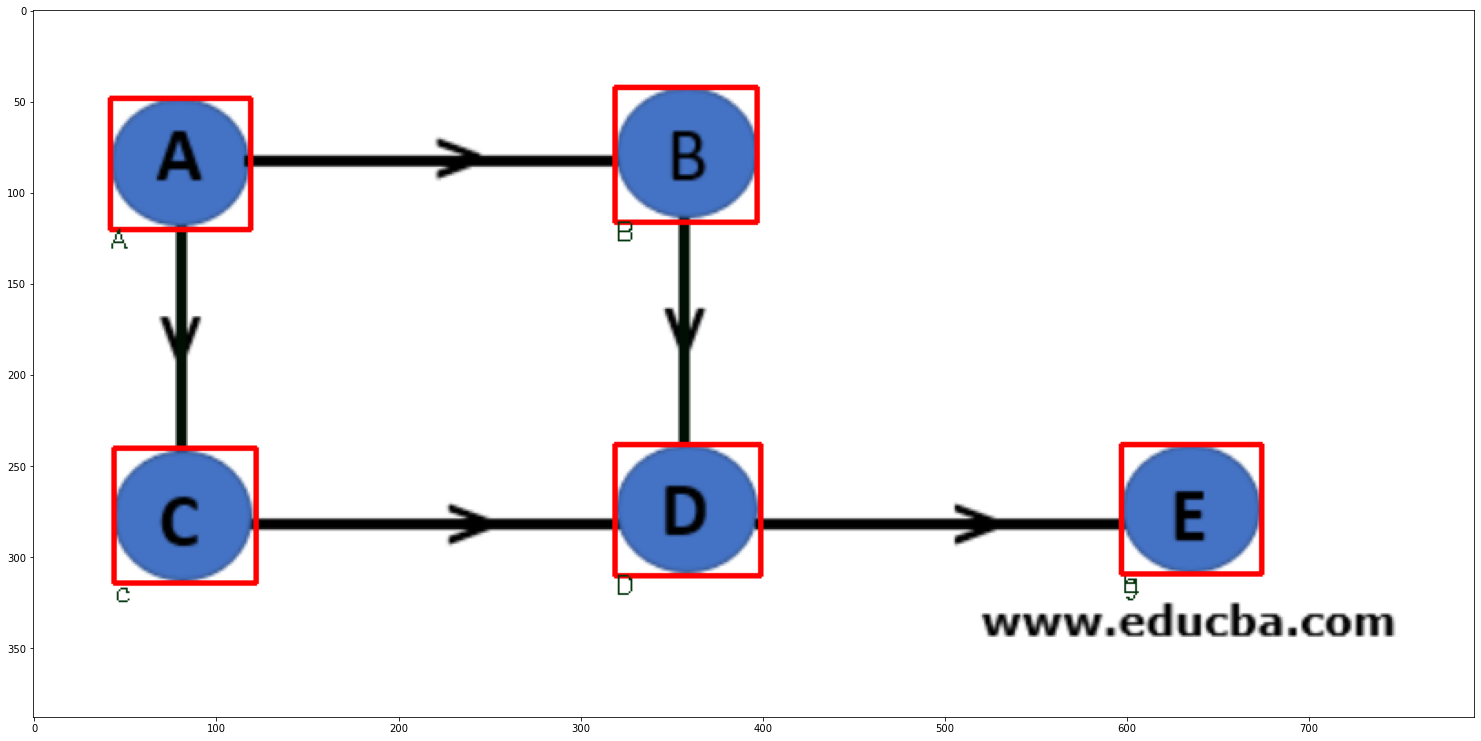

In [41]:
# dataset_path = "./dataset1/image"
# dataset_path = "/home/chenyang/code/CCKS2022/IconQA/data/ccksdata/train"
dataset_path = "/home/chenyang/code/CCKS2022/CSDQA_v2.1/data/diagram/Graph/"
img_name = "Graph_105.png"
img_full_name = os.path.join(dataset_path, img_name)
img = cv2.imread(img_full_name)
# img = threshold(img)
xy_list = get_xyxy_from_pic(img_full_name, model_test, score_thresh=0.7)
plt.figure(figsize=(35, 13))
draw_rect(img, xy_list)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(xy_list[0])